In [1]:
import openmc
import numpy as np
import time
import csv
import openmc.deplete

In [21]:
#need to pull the csv file that contains the isotopic composition, dashes have been omitted!!!!
comps = []
with open("6pass_comp.csv") as csvfile:
    reader = csv.reader(csvfile)#, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for row in reader: # each row is a list
        comps.append(row)
converted_data = [[item[0], float(item[1])] for item in comps]

#need to develop the fuel composition now
fuel = openmc.Material(name='Fuel')
fuel.set_density('g/cm3', 10.4)

for nuclide, ao in converted_data:
    fuel.add_nuclide(nuclide, ao)
    
#csv has natural C, need to add that back again with element this #Cnat	0.0177834267270722
fuel.add_element("C", 0.00177834267270722)
fuel.volume = 4.01943873*10**(-5)   #in cm3


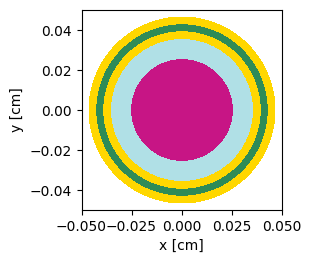

In [3]:
#need to develop the TRISO particle now!!!!
#need to add buffer layer:
Buffer = openmc.Material(name='Buffer')
Buffer.set_density('g/cm3', 1.02)
Buffer.add_element('C', 1.0)
Buffer.add_s_alpha_beta('c_Graphite')
t_Buffer = 0.01 #thickeness of buffer layer

#adding the PyC layer
PyC = openmc.Material(name='PyC1')
PyC.set_density('g/cm3', 1.92)
PyC.add_element('C', 1.0)
PyC.add_s_alpha_beta('c_Graphite')
tiPyC = 0.0039 #thickness of inner PyC
toPyC = tiPyC

#adding the SiC layer
SiC = openmc.Material(name='SiC')
SiC.set_density('g/cm3', 3.2)
SiC.add_element('C', 0.5)
SiC.add_element('Si', 0.5)
SiC.add_s_alpha_beta('c_Graphite')
tSic = 0.0035 #thickness of SiC

#outer pebble material
graphite = openmc.Material()
graphite.set_density('g/cm3', 1.7) #A3-3 Graphite
graphite.add_element('C', 1.0) 
graphite.add_s_alpha_beta('c_Graphite')


#cask fill insert, may also be helium
air = openmc.Material(name='air')
air.set_density('atom/b-cm', 0.0006) #'atom/b-cm', 0.0006
air.add_element('N',0.78)
air.add_element('O',0.21)
air.add_element('Ar',0.01)


#cask materials 

#inner cask
SS304 = openmc.Material(name = 'SS304')
SS304.set_density('g/cm3',7.93)
SS304.add_element('C',0.08/100,'wo')
SS304.add_element('P',0.045/100,'wo')
SS304.add_element('Si',0.75/100, 'wo')
SS304.add_element('Ni',13.5/100, 'wo')
SS304.add_element('N',0.1/100,'wo')
SS304.add_element('Mn',2/100, 'wo')
SS304.add_element('S',0.03/100,'wo')
SS304.add_element('Cr',19/100,'wo')
SS304.add_element('B',2.250/100,'wo')
SS304.add_element('Fe',62.245/100,'wo')
t_ss = 2 #cm

#concrete
conc = openmc.Material(name = 'conc')
conc.set_density('g/cm3',2.43)
conc.add_element('H',1,'wo')
#need to use mix materials to design this shielding cask 
#need a new method to approach the composition of dense concrete
t_conc = 20 #cm

#XM-19
xm19 = openmc.Material(name = 'xm19')
xm19.set_density('g/cm3',7.88)
xm19.add_element('Cr',22/100,'wo')
xm19.add_element('Ni',12.5/100,'wo')
xm19.add_element('Mn',5/100,'wo')
xm19.add_element('Mo',2.25/100,'wo')
xm19.add_element('Si',1/100,'wo')
xm19.add_element('N',0.3/100,'wo')
xm19.add_element('Nb',0.2/100,'wo')
xm19.add_element('P',0.2/100,'wo')
xm19.add_element('C',0.06/100,'wo')
xm19.add_element('S',0.01/100,'wo')
xm19.add_element('Fe',56.48/100,'wo')
t_xm19 = 10 #cm


#in centimeters (assuming it to be, looking at above units), need to check this with ZOE
#fuel pebble dimensions
peb_or = 3 #non-fuel portion
peb_ir = 2.5 #fuel portion

#TRISO particle dimensions
kernel_or = 0.02545 #radius of fuel kernel
buffer_r = kernel_or + t_Buffer
ipyc_r = buffer_r + tiPyC
sic_r = ipyc_r + tSic
opyc_r = sic_r + tiPyC #should be around 0.0455 cm, it is 0.04675

#core (cask) dimensions 
core_r = 0.5*100
core_h = 4.16*100

#more defining of our triso particles, all code below for developing our TRISO particles
kernelsph = openmc.Sphere(r=kernel_or)
buffsph = openmc.Sphere(r=buffer_r)
IPyCsph = openmc.Sphere(r=ipyc_r)
SiCsph = openmc.Sphere(r=sic_r)
OPyCsph = openmc.Sphere(r=opyc_r)

layers = [kernelsph, buffsph, IPyCsph, SiCsph, OPyCsph]
triso_mats = [fuel, Buffer, PyC, SiC, PyC]
triso_cells = []
for i in range(5):
  if (i == 0):
    triso_cells.append(openmc.Cell(fill=triso_mats[0], region=-layers[0]))
  else:
    triso_cells.append(openmc.Cell(fill=triso_mats[i], region=+layers[i-1] & -layers[i]))

triso_universe = openmc.Universe(cells=triso_cells)
triso_colors = {triso_cells[0]: (199,21,133), triso_cells[1]: (176,224,230), 
                triso_cells[2]: (255,215,0), triso_cells[3]: (46,139,87), 
                triso_cells[4]: (255,215, 0)}
triso_universe.plot(width = (0.1, 0.1), colors = triso_colors)

#defining region to fill our fuel pebbles with!!!!!
peb_wfuel = openmc.Sphere(r=peb_ir)
peb_wfuel_outer = -peb_wfuel

centers = openmc.model.pack_spheres(opyc_r, region=peb_wfuel_outer, num_spheres = 19000 ) #saying to fill only the fuel portion of the TRISO particle
#above function will pack pebbles into a sphere, it returns an array of positions that are used in the in next line of code 
trisos = [openmc.model.TRISO(kernel_or, triso_universe, center) for center in centers] # packs pebbles based on the centers positions array 
#print(centers) #this is the positions of the TRISO pebbles themselves

In [23]:
fuel

Material
	ID             =	11
	Name           =	Fuel
	Temperature    =	None
	Density        =	10.4 [g/cm3]
	Volume         =	4.01943873e-05 [cm^3]
	Depletable     =	True
	S(a,b) Tables  
	Nuclides       
	H3             =	1.50947446786796e-07 [ao]
	He3            =	1.50411765791463e-09 [ao]
	He4            =	3.42124627270645e-06 [ao]
	Li6            =	2.81534468374065e-08 [ao]
	Li7            =	1.10666782468796e-08 [ao]
	Be9            =	2.64539102058633e-09 [ao]
	B10            =	1.5317293302717e-09 [ao]
	B11            =	4.70408857210744e-10 [ao]
	N14            =	1.45648843257407e-12 [ao]
	N15            =	1.31245481758103e-09 [ao]
	O16            =	0.0861731554842243 [ao]
	O17            =	3.13016867923217e-08 [ao]
	Ca46           =	1.3158380659726e-26 [ao]
	Ca48           =	2.86288296154381e-31 [ao]
	Ti47           =	3.71843554069456e-24 [ao]
	Ti48           =	2.6913922850073e-25 [ao]
	Ti49           =	2.37912391531695e-22 [ao]
	Ti50           =	3.32962572352164e-15 [ao]
	Cr52    

In [22]:
#need to develop the geometry of our cask as a region
inner_cask = openmc.ZCylinder(r=0.5)
maxz = openmc.ZPlane(z0=core_h/2, boundary_type='white')
minz = openmc.ZPlane(z0=-core_h/2, boundary_type='white')

lattice_region = -inner_cask & -maxz & +minz

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

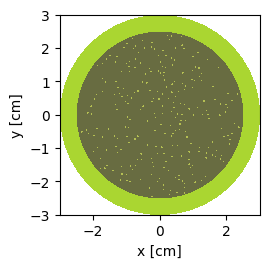

In [5]:
#generating the fuel pebbler
peb_nofuel = openmc.Sphere(r=peb_or) #generates a sphere of this radius
peb_nofuel_zone_outer = -peb_nofuel 
peb_nofuel_zone_inner = +peb_wfuel #creates a non-fuel region for our pebble
peb_fuel_zone = -peb_wfuel

sphere = openmc.Cell(region=peb_wfuel_outer) #only focusing on fuel containing portion of our fuel pebble
lower_left, upper_right = sphere.region.bounding_box
shape = (1,1,1) #Number of lattice elements in the x-, y-, and z-directions, look at the example in the repo
pitch = (upper_right - lower_left)/shape
lattice = openmc.model.create_triso_lattice(
    trisos, lower_left, pitch, shape, graphite)
sphere.fill = lattice

pebble_element = [sphere,
              openmc.Cell(fill=graphite, region=peb_nofuel_zone_inner & peb_nofuel_zone_outer)]
pebble_univ = openmc.Universe(cells=pebble_element)

active_core_sides = openmc.ZCylinder(r = core_r)
active_core_top = openmc.ZPlane(z0=(core_h/2))
active_core_bot = openmc.ZPlane(z0=-(core_h/2))
active_core_bound = -active_core_sides & -active_core_top & +active_core_bot
pebble_univ.plot()

In [6]:
#code to get the location data for the individual fuel pebbles!!!!!
results = []
new_row = []
with open("position for pebbles/settlephase_final_positions.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for row in reader: # each row is a list
        results.append(row)
      
def multiply_list_by_scalar(list_of_lists, scalar):
    output = [[element * scalar for element in sub_list] for sub_list in list_of_lists]
    return output

# Example usage:
my_list = results
scalar_value = 100
multiplied_list = multiply_list_by_scalar(my_list, scalar_value)
multiplied_list[0] 

[-9.26872, -46.08, -205.00500000000002]

In [7]:
print("starting openmc pack")
start_time = time.perf_counter()
peb_centers = multiplied_list
#openmc.model.pack_spheres(peb_or, region=active_core_bound, pf = .40, contraction_rate = 0.0000001)
#need to implement this as an array of a bunch of position arrays, this might be randomly generated
print(time.perf_counter()-start_time)

pebs = [openmc.model.TRISO(peb_or, pebble_univ, peb_center) for peb_center in peb_centers] #display the locations of these pebbles using the ARFC computer
#implement our pebble locations

peb_centertest = np.vstack([peb.center for peb in pebs]) #veritically stacks the above array to easily read the positions of the pebbles
print(peb_centertest.min(axis=0))
print(peb_centertest.max(axis=0))

inner_core = openmc.Cell(region=active_core_bound)
lower_left_core, upper_right_core = inner_core.region.bounding_box
shape_core = (1,1,1)
pitch_core = (upper_right_core - lower_left_core)/shape_core
core_lattice = openmc.model.create_triso_lattice(
    pebs, lower_left_core, pitch_core, shape_core, air)

inner_core.fill=core_lattice

starting openmc pack
0.00017627800116315484
[ -47.0057  -47.0039 -205.013 ]
[ 47.0076  47.0086 199.709 ]


/home/ceserz2/anaconda3/envs/lammps-openmc/lib/python3.12/site-packages/openmc/model/triso.py:850: UserWarning: TRISO particle is partially or completely outside of the lattice.
  warnings.warn('TRISO particle is partially or completely '


<Axes: xlabel='x [cm]', ylabel='y [cm]'>

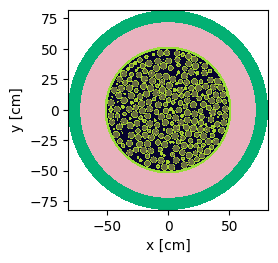

In [8]:
#AGAIN, looking at adding material surrounding the core (or our cask)

#inner cask only
inner_cask_sides = openmc.ZCylinder(r = (core_r+t_ss), boundary_type='white')
inner_cask_top = openmc.ZPlane(z0=((core_h/2)+t_ss),boundary_type='white')
inner_cask_bot = openmc.ZPlane(z0=-((core_h/2)+t_ss),boundary_type='white')
inner_cask_outer = -inner_cask_sides & -inner_cask_top & +inner_cask_bot
inner_cask_bounds = inner_cask_outer | active_core_bound
inner = openmc.Cell(region = inner_cask_bounds, fill = SS304)

#concrete shielding now!!!!
r_conc_in = core_r+t_ss
r_conc_tot = r_conc_in+t_conc
conc_sides = openmc.ZCylinder(r = r_conc_tot, boundary_type='white')
conc_top = openmc.ZPlane(z0=r_conc_tot,boundary_type='white')
conc_bot = openmc.ZPlane(z0=-r_conc_tot,boundary_type='white')
conc_outer = -conc_sides & -conc_top & +conc_bot
conc_cask_bounds = conc_outer | active_core_bound
concrete = openmc.Cell(region = conc_cask_bounds, fill = conc)

#concrete shielding now!!!!
r_xm19_in = r_conc_tot
r_xm19_tot = r_conc_tot+t_xm19
xm19_sides = openmc.ZCylinder(r = r_xm19_tot, boundary_type='white')
xm19_top = openmc.ZPlane(z0=r_xm19_tot,boundary_type='white')
xm19_bot = openmc.ZPlane(z0=-r_xm19_tot,boundary_type='white')
xm19_outer = -xm19_sides & -xm19_top & +xm19_bot
xm19_cask_bounds = xm19_outer | active_core_bound
impact = openmc.Cell(region = xm19_cask_bounds, fill = xm19)
universe = openmc.Universe(cells=[inner_core,inner,concrete,impact])
universe.plot()

In [15]:
#model has been developed, time to set-up depletion
geometry = openmc.Geometry(universe)
settings = openmc.Settings()
settings.particles = 10000
settings.inactive = 10
settings.batches = 50

In [16]:
chain = openmc.deplete.Chain.from_xml("./chain_endfb71_pwr.xml")
#chain.nuclide_dict
chain.add_nuclide

<bound method Chain.add_nuclide of <openmc.deplete.chain.Chain object at 0x712343876660>>

In [17]:
chain.nuclides

[<Nuclide: H1 (0 modes, 1 reactions)>,
 <Nuclide: H2 (0 modes, 2 reactions)>,
 <Nuclide: H3 (1 modes, 1 reactions)>,
 <Nuclide: H4 (1 modes, 0 reactions)>,
 <Nuclide: H5 (1 modes, 0 reactions)>,
 <Nuclide: H6 (1 modes, 0 reactions)>,
 <Nuclide: H7 (1 modes, 0 reactions)>,
 <Nuclide: He3 (0 modes, 2 reactions)>,
 <Nuclide: He4 (0 modes, 0 reactions)>,
 <Nuclide: He5 (1 modes, 0 reactions)>,
 <Nuclide: He6 (1 modes, 0 reactions)>,
 <Nuclide: He7 (1 modes, 0 reactions)>,
 <Nuclide: He8 (2 modes, 0 reactions)>,
 <Nuclide: He9 (1 modes, 0 reactions)>,
 <Nuclide: He10 (1 modes, 0 reactions)>,
 <Nuclide: Li4 (1 modes, 0 reactions)>,
 <Nuclide: Li5 (1 modes, 0 reactions)>,
 <Nuclide: Li6 (0 modes, 2 reactions)>,
 <Nuclide: Li7 (0 modes, 2 reactions)>,
 <Nuclide: Li8 (1 modes, 0 reactions)>,
 <Nuclide: Li9 (2 modes, 0 reactions)>,
 <Nuclide: Li10 (1 modes, 0 reactions)>,
 <Nuclide: Li11 (1 modes, 0 reactions)>,
 <Nuclide: Li12 (1 modes, 0 reactions)>,
 <Nuclide: Be5 (1 modes, 0 reactions)>,
 <N

In [18]:
model = openmc.Model(geometry=geometry, settings=settings)
op = openmc.deplete.CoupledOperator(model,chain_file="./chain_endfb71_pwr.xml")
timesteps = [1]*365*3
power = 0
x = openmc.deplete.CECMIntegrator(op, timesteps, power, timestep_units='d')

In [19]:
x.integrate()

KeyError: 'No material exists with ID=1.'